In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


## Step 1: Preprocess ZORI Rent Data

Filter to Bay Area zip codes and calculate 12-month average rent.


In [ ]:
print("Loading ZORI rent data...")
zori_df = pd.read_csv('raw_data/Zip_zori_uc_sfrcondomfr_sm_month.csv')

print(f"Total rows in ZORI data: {len(zori_df):,}")
print(f"Columns: {list(zori_df.columns[:10])}...")

bay_area_metros = [
    "San Francisco-Oakland-Berkeley, CA",
    "San Jose-Sunnyvale-Santa Clara, CA"
]

bay_area_zori = zori_df[zori_df['Metro'].isin(bay_area_metros)].copy()
print(f"\nBay Area zip codes found: {len(bay_area_zori):,}")

date_columns = [col for col in zori_df.columns if col.startswith('2024') or col.startswith('2025')]
date_columns = sorted(date_columns, reverse=True)[:12]  # Get last 12 months
print(f"\nUsing last 12 months: {date_columns[0]} to {date_columns[-1]}")


Loading ZORI rent data...
Total rows in ZORI data: 7,822
Columns: ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2015-01-31']...

Bay Area zip codes found: 182

Using last 12 months: 2025-10-31 to 2024-11-30


In [5]:
def calculate_avg_rent(row):
    """Calculate average rent over last 12 months"""
    rents = []
    for col in date_columns:
        val = row[col]
        if pd.notna(val) and val != '':
            try:
                rents.append(float(val))
            except:
                pass
    return np.mean(rents) if rents else np.nan

bay_area_zori['avg_rent_12mo'] = bay_area_zori.apply(calculate_avg_rent, axis=1)

rent_data = bay_area_zori[['RegionName', 'City', 'CountyName', 'Metro', 'avg_rent_12mo']].copy()
rent_data.columns = ['zip', 'city', 'county', 'metro', 'avg_rent']
rent_data['zip'] = rent_data['zip'].astype(str).str.zfill(5)  

rent_data = rent_data[rent_data['avg_rent'].notna()].copy()

print(f"Zip codes with valid rent data: {len(rent_data):,}")
print(f"\nRent statistics:")
print(rent_data['avg_rent'].describe())

rent_data.to_csv('cleaned_data/bay_area_rent_data.csv', index=False)

Zip codes with valid rent data: 182

Rent statistics:
count      182.000000
mean      3446.746153
std       1808.274411
min       1981.017635
25%       2788.618332
50%       3273.202640
75%       3661.845329
max      25500.000000
Name: avg_rent, dtype: float64


## Step 2: Extend Attraction Scores to All Bay Area Zip Codes

Calculate attraction metrics for all zip codes using the full Yelp dataset.


In [6]:
print("Loading Yelp business data...")
yelp_df = pd.read_csv('../eda/bay_area_yelp_businesses_with_labels.csv')

print(f"Total businesses: {len(yelp_df):,}")
print(f"Unique zip codes: {yelp_df['zip'].nunique()}")

yelp_df['zip'] = yelp_df['zip'].astype(str).str.zfill(5)

bay_area_zips = set(rent_data['zip'].unique())
yelp_df_filtered = yelp_df[yelp_df['zip'].isin(bay_area_zips)].copy()

print(f"\nBusinesses in Bay Area zip codes: {len(yelp_df_filtered):,}")
print(f"Unique Bay Area zip codes with Yelp data: {yelp_df_filtered['zip'].nunique()}")


Loading Yelp business data...
Total businesses: 12,123
Unique zip codes: 11

Businesses in Bay Area zip codes: 12,123
Unique Bay Area zip codes with Yelp data: 11


In [7]:
print("Calculating attraction scores for each zip code...")

attraction_stats = yelp_df_filtered.groupby('zip').agg({
    'is_gentrified': ['sum', 'mean', 'count'],
    'gentrification_score': 'mean',
    'price': lambda x: (x.isin(['$$$', '$$$$']).sum() / len(x) if len(x) > 0 else 0),
    'rating': 'mean',
    'review_count': 'mean'
}).round(3)

attraction_stats.columns = ['gentrified_count', 'gentrified_pct', 'total_businesses', 
                            'avg_gentrification_score', 'high_price_pct', 
                            'avg_rating', 'avg_review_count']

attraction_stats = attraction_stats.reset_index()


attraction_stats['attraction_score'] = (
    attraction_stats['gentrified_pct'] * 0.3 +  # Weight: gentrification percentage
    (attraction_stats['avg_gentrification_score'] / 7) * 0.2 +  # Normalized gentrification score (max ~7)
    (attraction_stats['avg_rating'] / 5) * 0.2 +  # Normalized rating (max 5)
    (attraction_stats['high_price_pct']) * 0.15 +  # High-price business percentage
    (np.log1p(attraction_stats['total_businesses']) / np.log1p(attraction_stats['total_businesses'].max())) * 0.15  # Business density (log scale)
)

print(f"Attraction scores calculated for {len(attraction_stats)} zip codes")
print(f"\nAttraction score statistics:")
print(attraction_stats['attraction_score'].describe())

attraction_stats.to_csv('cleaned_data/bay_area_attraction_scores.csv', index=False)


Calculating attraction scores for each zip code...
Attraction scores calculated for 11 zip codes

Attraction score statistics:
count    11.000000
mean      0.511509
std       0.033123
min       0.457588
25%       0.494574
50%       0.503044
75%       0.523780
max       0.579602
Name: attraction_score, dtype: float64


## Step 3: Merge Rent and Attraction Data


In [8]:
print("Merging rent and attraction data...")

merged_df = rent_data.merge(attraction_stats, on='zip', how='left')

print(f"Total zip codes after merge: {len(merged_df):,}")
print(f"Zip codes with both rent and attraction data: {merged_df['attraction_score'].notna().sum():,}")
print(f"Zip codes with rent but no attraction data: {merged_df['attraction_score'].isna().sum():,}")

merged_df['attraction_score'] = merged_df['attraction_score'].fillna(0)
merged_df['gentrified_pct'] = merged_df['gentrified_pct'].fillna(0)
merged_df['total_businesses'] = merged_df['total_businesses'].fillna(0)
merged_df['avg_rating'] = merged_df['avg_rating'].fillna(0)

print(f"\nFinal dataset shape: {merged_df.shape}")


Merging rent and attraction data...
Total zip codes after merge: 182
Zip codes with both rent and attraction data: 11
Zip codes with rent but no attraction data: 171

Final dataset shape: (182, 13)


## Step 4: Feature Engineering and Normalization


In [9]:
# For rent: we want to minimize, so use inverse normalization
# For attractions: we want to maximize, so use standard normalization

merged_df_clean = merged_df[merged_df['avg_rent'].notna()].copy()
merged_df_clean = merged_df_clean[merged_df_clean['avg_rent'] > 0].copy()

# Normalize rent (inverse - lower rent is better)
rent_min = merged_df_clean['avg_rent'].min()
rent_max = merged_df_clean['avg_rent'].max()
merged_df_clean['rent_normalized'] = 1 - ((merged_df_clean['avg_rent'] - rent_min) / (rent_max - rent_min))

# Normalize attraction score (standard - higher is better)
attraction_min = merged_df_clean['attraction_score'].min()
attraction_max = merged_df_clean['attraction_score'].max()
if attraction_max > attraction_min:
    merged_df_clean['attraction_normalized'] = (merged_df_clean['attraction_score'] - attraction_min) / (attraction_max - attraction_min)
else:
    merged_df_clean['attraction_normalized'] = 0.5  # Default if all same

print("Feature normalization complete!")
print(f"\nRent range: ${rent_min:.0f} - ${rent_max:.0f}")
print(f"Attraction score range: {attraction_min:.3f} - {attraction_max:.3f}")


Feature normalization complete!

Rent range: $1981 - $25500
Attraction score range: 0.000 - 0.580


## Step 5: Build Recommender Function

Using weighted scoring approach: `score = w1 * normalized_attractions - w2 * normalized_rent`


In [10]:
def recommend_zip_codes(
    df, 
    attraction_weight=0.6, 
    rent_weight=0.4,
    max_rent=None,
    min_attraction_score=None,
    top_n=20
):
    """
    Recommend best zip codes based on weighted scoring.
    """
    result_df = df.copy()
    
    if max_rent is not None:
        result_df = result_df[result_df['avg_rent'] <= max_rent]
    
    if min_attraction_score is not None:
        result_df = result_df[result_df['attraction_score'] >= min_attraction_score]

    result_df['recommendation_score'] = (
        attraction_weight * result_df['attraction_normalized'] + 
        rent_weight * result_df['rent_normalized']
    )
    
    result_df = result_df.sort_values('recommendation_score', ascending=False)
    
    top_recommendations = result_df.head(top_n).copy()
    
    output_cols = ['zip', 'city', 'county', 'metro', 'avg_rent', 
                   'attraction_score', 'gentrified_pct', 'total_businesses', 
                   'avg_rating', 'recommendation_score']
    
    return top_recommendations[output_cols]


## Step 6: Generate Recommendations

Let's get the top recommendations with default weights (60% attractions, 40% rent).


In [11]:
# Get top recommendations
ATTRACTION_WEIGHT = 0.6
RENT_WEIGHT = 0.4

recommendations = recommend_zip_codes(
    merged_df_clean,
    attraction_weight=ATTRACTION_WEIGHT,
    rent_weight=RENT_WEIGHT,
    top_n=30
)

# Store the recommendation score on the full dataset for downstream visualizations
merged_df_clean['recommendation_score'] = (
    ATTRACTION_WEIGHT * merged_df_clean['attraction_normalized'] +
    RENT_WEIGHT * merged_df_clean['rent_normalized']
)

recommendations.to_csv("cleaned_data/recommended_zip_codes.csv", index=False)
print("Recommendations saved to 'cleaned_data/recommended_zip_codes.csv'\n")

print("=" * 80)
print("TOP 30 RECOMMENDED ZIP CODES FOR YOUNG ADULTS")
print("=" * 80)
print(f"\nScoring: {int(ATTRACTION_WEIGHT * 100)}% Attractions, {int(RENT_WEIGHT * 100)}% Affordability (lower rent)\n")

for rank, (idx, row) in enumerate(recommendations.iterrows(), 1):
    print(f"{rank:2d}. Zip {row['zip']} - {row['city']}, {row['county']}")
    print(f"    Rent: ${row['avg_rent']:.0f}/mo  |  Attraction Score: {row['attraction_score']:.3f}  |  Recommendation Score: {row['recommendation_score']:.3f}")
    print(f"    Gentrified %: {row['gentrified_pct']*100:.1f}%  |  Businesses: {int(row['total_businesses'])}  |  Avg Rating: {row['avg_rating']:.2f}")
    print()


Recommendations saved to 'cleaned_data/recommended_zip_codes.csv'

TOP 30 RECOMMENDED ZIP CODES FOR YOUNG ADULTS

Scoring: 60% Attractions, 40% Affordability (lower rent)

 1. Zip 94117 - San Francisco, San Francisco County
    Rent: $3686/mo  |  Attraction Score: 0.580  |  Recommendation Score: 0.971
    Gentrified %: 59.4%  |  Businesses: 1262  |  Avg Rating: 3.91

 2. Zip 94110 - San Francisco, San Francisco County
    Rent: $3701/mo  |  Attraction Score: 0.550  |  Recommendation Score: 0.940
    Gentrified %: 56.2%  |  Businesses: 938  |  Avg Rating: 3.93

 3. Zip 94109 - San Francisco, San Francisco County
    Rent: $2759/mo  |  Attraction Score: 0.520  |  Recommendation Score: 0.925
    Gentrified %: 43.2%  |  Businesses: 1207  |  Avg Rating: 3.84

 4. Zip 94103 - San Francisco, San Francisco County
    Rent: $3334/mo  |  Attraction Score: 0.527  |  Recommendation Score: 0.923
    Gentrified %: 44.9%  |  Businesses: 1344  |  Avg Rating: 3.86

 5. Zip 94709 - Berkeley, Alameda Cou

## Step 7: Visualizations


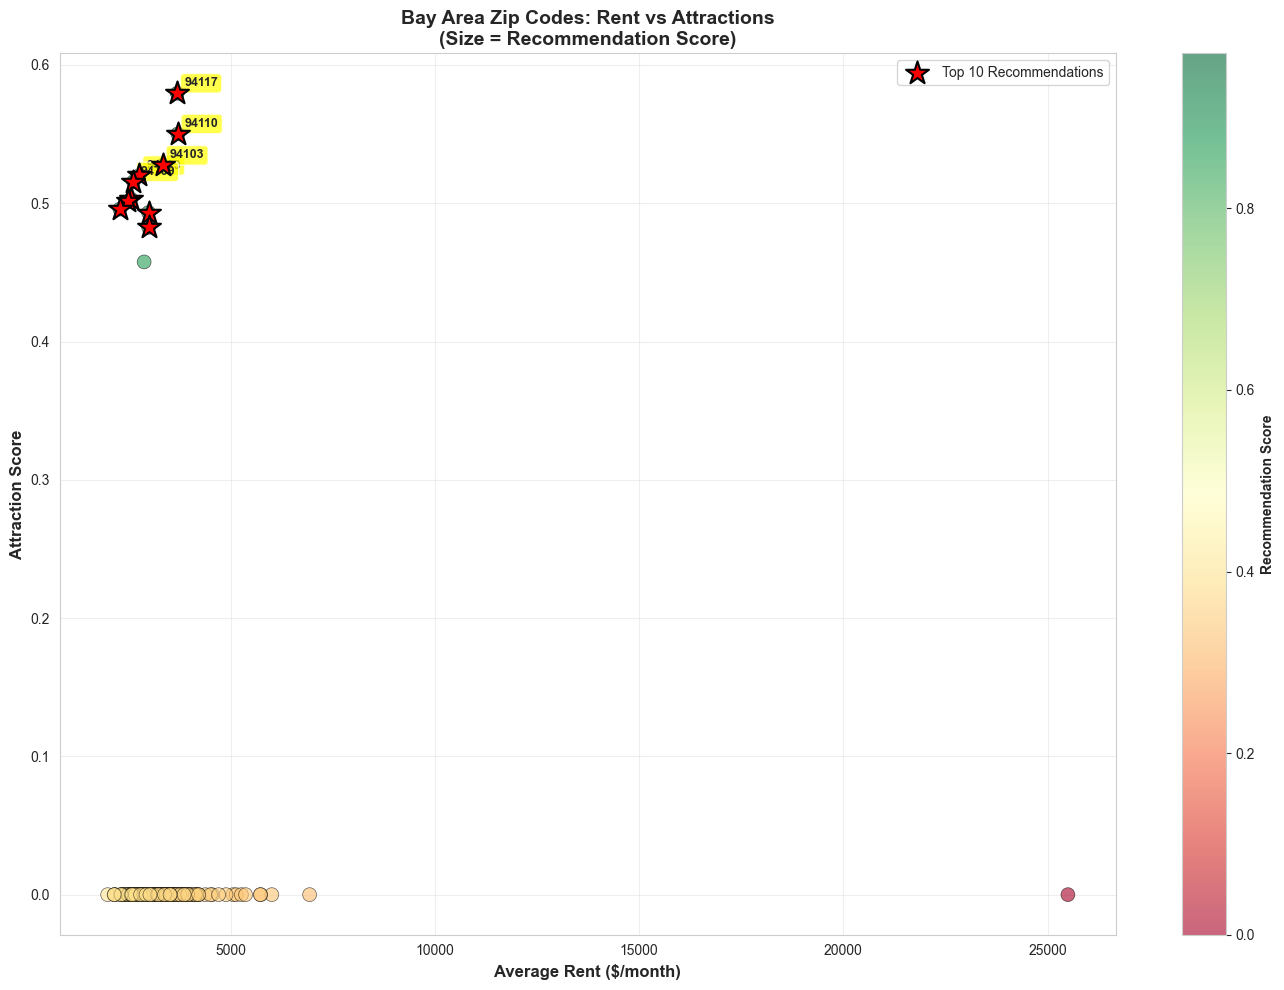

✅ Scatter plot saved as 'outputs/rent_vs_attractions.png'


In [12]:
# Scatter plot: Rent vs Attractions
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all zip codes
scatter = ax.scatter(merged_df_clean['avg_rent'], 
                     merged_df_clean['attraction_score'],
                     c=merged_df_clean['recommendation_score'],
                     cmap='RdYlGn',
                     alpha=0.6,
                     s=100,
                     edgecolors='black',
                     linewidth=0.5)

# Highlight top 10 recommendations
top_10 = recommendations.head(10)
ax.scatter(top_10['avg_rent'], 
           top_10['attraction_score'],
           color='red',
           s=300,
           marker='*',
           edgecolors='black',
           linewidth=1.5,
           label='Top 10 Recommendations',
           zorder=5)

# Add labels for top 5
for idx, row in top_10.head(5).iterrows():
    ax.annotate(f"{row['zip']}", 
                (row['avg_rent'], row['attraction_score']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Average Rent ($/month)', fontsize=12, fontweight='bold')
ax.set_ylabel('Attraction Score', fontsize=12, fontweight='bold')
ax.set_title('Bay Area Zip Codes: Rent vs Attractions\n(Size = Recommendation Score)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Recommendation Score', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/rent_vs_attractions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Scatter plot saved as 'outputs/rent_vs_attractions.png'")


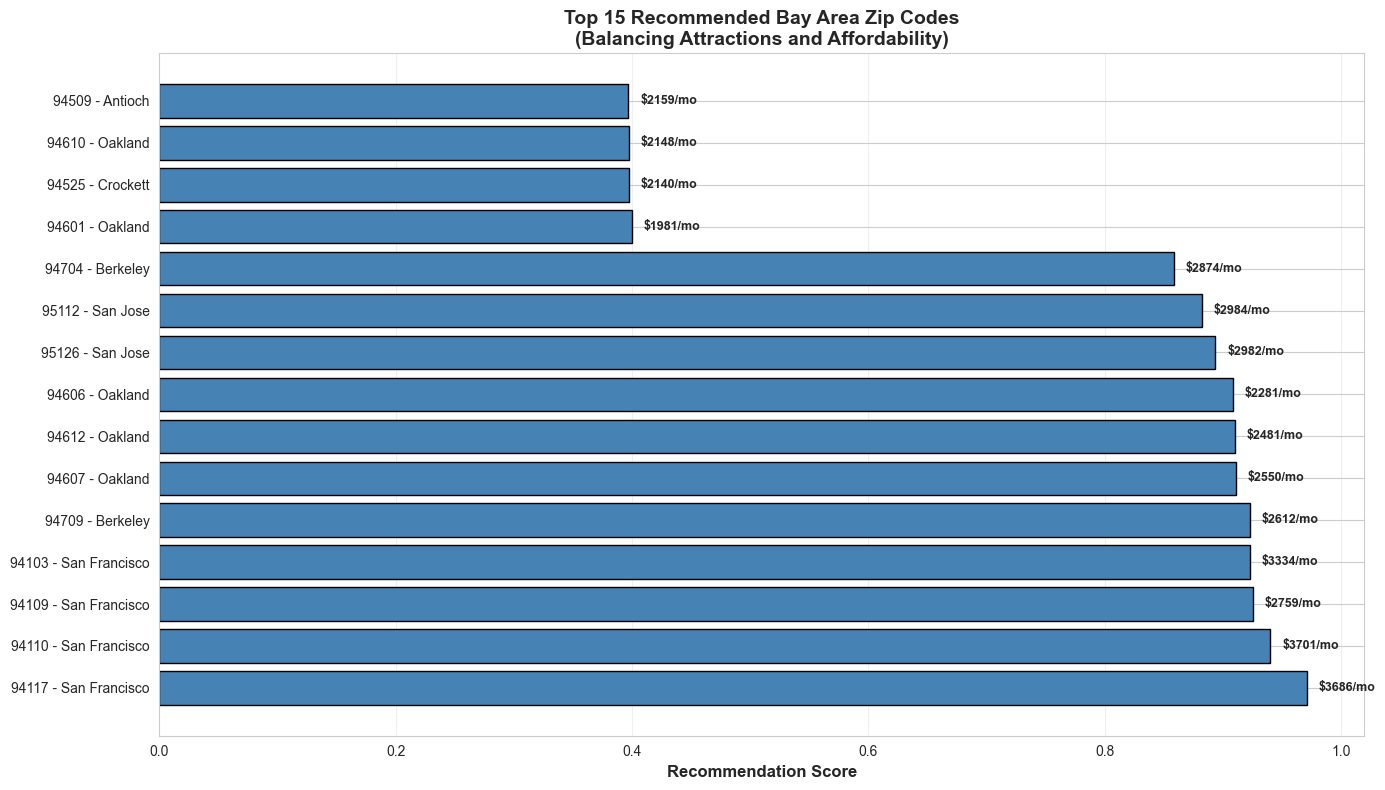

✅ Bar chart saved as 'outputs/top_recommendations.png'


In [13]:
# Bar chart: Top 15 recommendations
fig, ax = plt.subplots(figsize=(14, 8))

top_15 = recommendations.head(15)
y_pos = np.arange(len(top_15))

# Create horizontal bar chart
bars = ax.barh(y_pos, top_15['recommendation_score'], 
               color='steelblue', edgecolor='black', linewidth=1)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{row['zip']} - {row['city']}" for _, row in top_15.iterrows()], 
                    fontsize=10)
ax.set_xlabel('Recommendation Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Recommended Bay Area Zip Codes\n(Balancing Attractions and Affordability)', 
             fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top_15.iterrows()):
    score = row['recommendation_score']
    rent = row['avg_rent']
    ax.text(score + 0.01, i, f'${rent:.0f}/mo', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/top_recommendations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Bar chart saved as 'outputs/top_recommendations.png'")


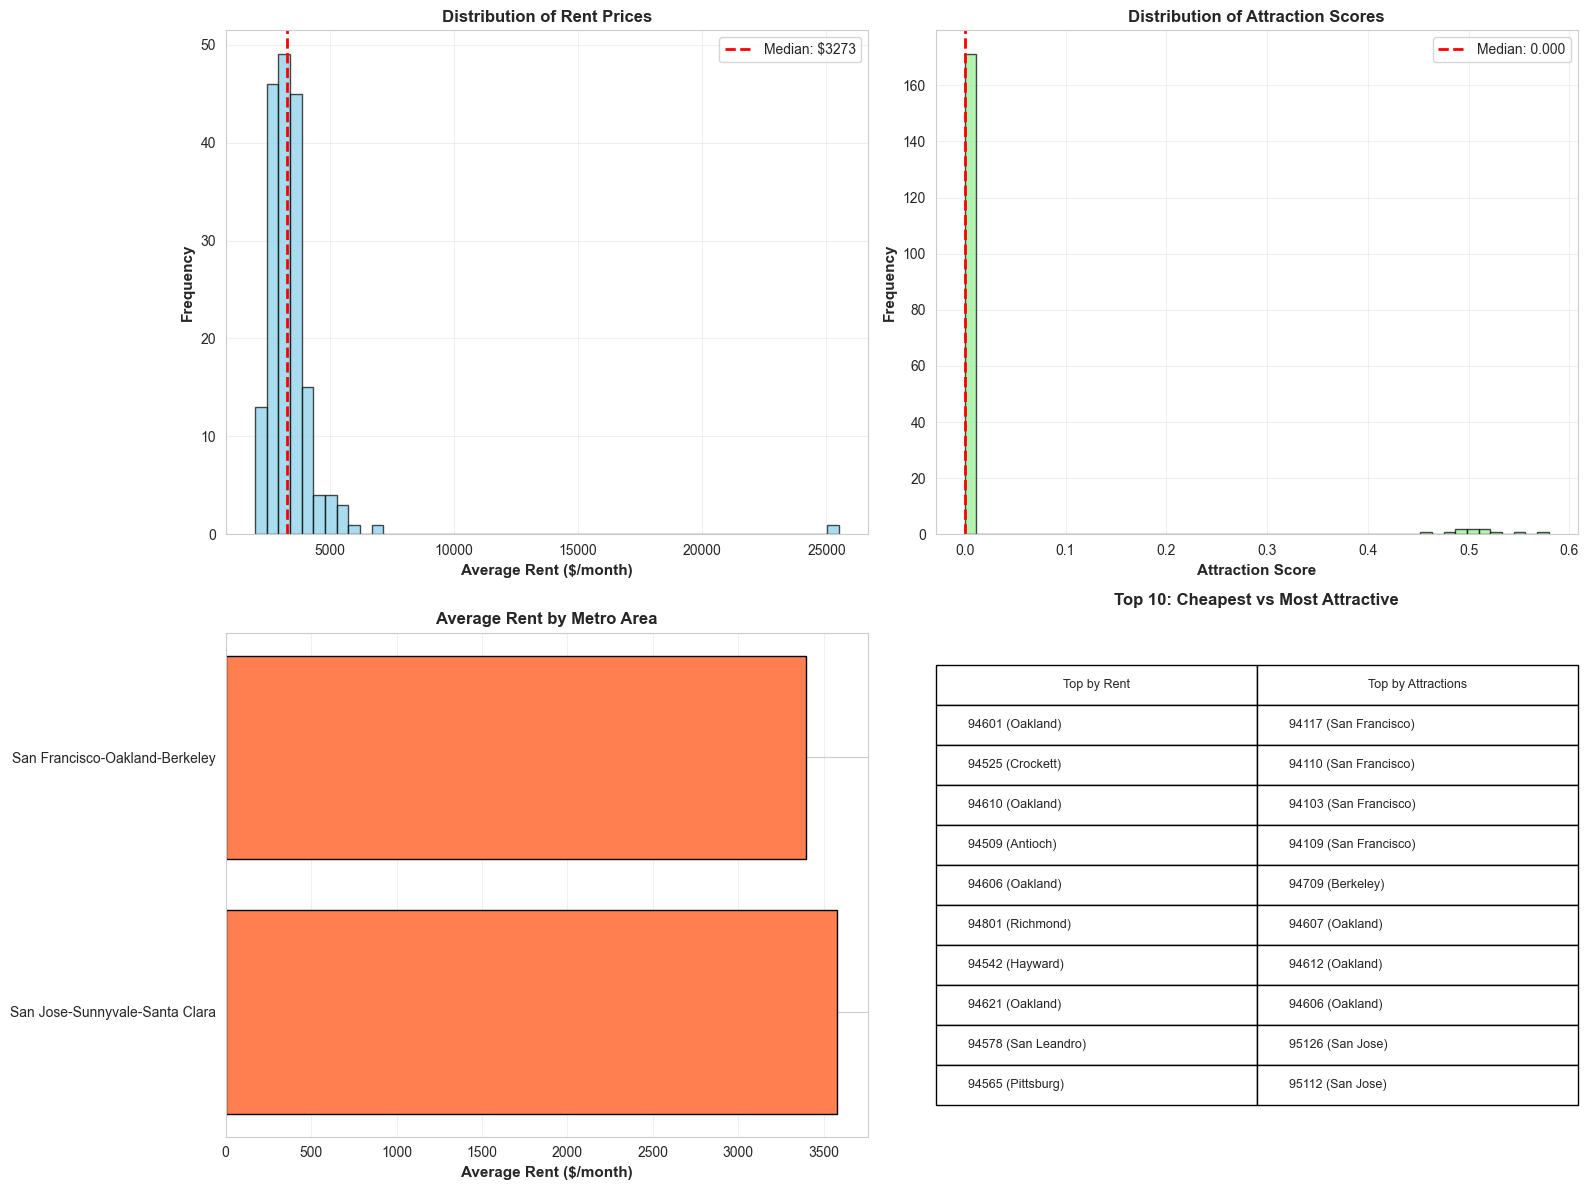

✅ Distribution analysis saved as 'outputs/distribution_analysis.png'


In [14]:
# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rent distribution
axes[0, 0].hist(merged_df_clean['avg_rent'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(merged_df_clean['avg_rent'].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: ${merged_df_clean["avg_rent"].median():.0f}')
axes[0, 0].set_xlabel('Average Rent ($/month)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Rent Prices', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Attraction score distribution
axes[0, 1].hist(merged_df_clean['attraction_score'], bins=50, color='lightgreen', 
                edgecolor='black', alpha=0.7)
axes[0, 1].axvline(merged_df_clean['attraction_score'].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {merged_df_clean["attraction_score"].median():.3f}')
axes[0, 1].set_xlabel('Attraction Score', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Attraction Scores', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Rent by metro area
metro_rent = merged_df_clean.groupby('metro')['avg_rent'].mean().sort_values(ascending=False)
axes[1, 0].barh(range(len(metro_rent)), metro_rent.values, color='coral', edgecolor='black')
axes[1, 0].set_yticks(range(len(metro_rent)))
axes[1, 0].set_yticklabels([m.split(',')[0] for m in metro_rent.index], fontsize=10)
axes[1, 0].set_xlabel('Average Rent ($/month)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Rent by Metro Area', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, axis='x', alpha=0.3)

# 4. Top 10 by different metrics
top_by_rent = merged_df_clean.nsmallest(10, 'avg_rent')[['zip', 'city', 'avg_rent']]
top_by_attractions = merged_df_clean.nlargest(10, 'attraction_score')[['zip', 'city', 'attraction_score']]

# Create comparison
comparison_data = pd.DataFrame({
    'Top by Rent': [f"{row['zip']} ({row['city']})" for _, row in top_by_rent.iterrows()],
    'Top by Attractions': [f"{row['zip']} ({row['city']})" for _, row in top_by_attractions.iterrows()]
})

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=comparison_data.values,
                         colLabels=comparison_data.columns,
                         cellLoc='left',
                         loc='center',
                         colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
axes[1, 1].set_title('Top 10: Cheapest vs Most Attractive', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('outputs/distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution analysis saved as 'outputs/distribution_analysis.png'")


## Step 7A: Interactive Map of Recommended Zip Codes

Visualize how rent and attraction scores come together spatially by plotting the Bay Area zip codes on an interactive Folium map. Popular (high-scoring) areas are highlighted so the hotspots are easy to spot at a glance.


In [15]:
import importlib
import subprocess
import sys


def ensure_package(module_name, install_name=None):
    """Import a module, installing it if necessary."""
    try:
        return importlib.import_module(module_name)
    except ImportError:
        target = install_name or module_name
        print(f"Installing missing dependency: {target}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", target])
        return importlib.import_module(module_name)


folium = ensure_package("folium")
pgeocode = ensure_package("pgeocode")
branca_colormap = ensure_package("branca.colormap")
linear = branca_colormap.linear

nomi = pgeocode.Nominatim("us")
map_df = merged_df_clean.copy().reset_index(drop=True)
coord_df = nomi.query_postal_code(map_df["zip"].tolist())

map_df["latitude"] = coord_df["latitude"].values
map_df["longitude"] = coord_df["longitude"].values
map_df = map_df.dropna(subset=["latitude", "longitude"]).copy()
map_df["is_top"] = map_df["zip"].isin(recommendations.head(10)["zip"]).astype(int)

score_min = float(map_df["recommendation_score"].min())
score_max = float(map_df["recommendation_score"].max())
color_scale = linear.YlOrRd_09.scale(score_min, score_max)
color_scale.caption = "Recommendation Score"

bay_center = [37.7749, -122.4194]
reco_map = folium.Map(location=bay_center, zoom_start=10, tiles="cartodbpositron")

for _, row in map_df.iterrows():
    popup_html = (
        f"<strong>Zip {row['zip']}</strong><br>"
        f"{row['city']}, {row['county']}<br>"
        f"Rent: ${row['avg_rent']:.0f}/mo<br>"
        f"Attraction Score: {row['attraction_score']:.3f}<br>"
        f"Recommendation Score: {row['recommendation_score']:.3f}<br>"
        f"Businesses: {int(row['total_businesses'])}"
    )

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=12 if row["is_top"] else 7,
        color="black" if row["is_top"] else "#333333",
        weight=1.5 if row["is_top"] else 0.5,
        fill=True,
        fill_color=color_scale(row["recommendation_score"]),
        fill_opacity=0.85 if row["is_top"] else 0.65,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(reco_map)

color_scale.add_to(reco_map)

map_output_path = "outputs/bay_area_recommendations_map.html"
reco_map.save(map_output_path)

print(f"✅ Interactive map saved to '{map_output_path}'")
reco_map


✅ Interactive map saved to 'outputs/bay_area_recommendations_map.html'


## Step 8: Export Results


In [16]:
# Export top recommendations with full details
export_df = recommendations.copy()

# Add more context columns
export_df = export_df.merge(
    merged_df_clean[['zip', 'gentrified_count', 'high_price_pct', 'avg_review_count']],
    on='zip',
    how='left'
)

# Round numeric columns
export_df['avg_rent'] = export_df['avg_rent'].round(0)
export_df['attraction_score'] = export_df['attraction_score'].round(3)
export_df['recommendation_score'] = export_df['recommendation_score'].round(3)
export_df['gentrified_pct'] = (export_df['gentrified_pct'] * 100).round(1)
export_df['avg_rating'] = export_df['avg_rating'].round(2)

# Reorder columns for better readability
export_df = export_df[[
    'zip', 'city', 'county', 'metro',
    'avg_rent', 'attraction_score', 'recommendation_score',
    'gentrified_pct', 'total_businesses', 'gentrified_count',
    'avg_rating', 'avg_review_count', 'high_price_pct'
]]

export_df.to_csv('cleaned_data/top_recommendations.csv', index=False)
